In [10]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [35]:
# ============================================================================
# COMPLETE ANTI-MONEY LAUNDERING DETECTION SYSTEM WITH ENHANCEMENTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, precision_score, recall_score)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

# Advanced ML Libraries  
import xgboost as xgb
import lightgbm as lgb

# Model Interpretation
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("=== ENHANCED AML DETECTION SYSTEM ===")



=== ENHANCED AML DETECTION SYSTEM ===


In [36]:
# ============================================================================
# 1. DATA LOADING AND INITIAL PREPROCESSING
# ============================================================================

def load_and_preprocess_data():
    """Load and perform initial preprocessing of SAML-D dataset"""
    print("\n1. Loading SAML-D dataset...")

    # Load the dataset
    df = pd.read_csv("SAML-D.csv")
    print(f"Original dataset shape: {df.shape}")

    # Sample data for manageable processing (adjust as needed)
    df = df.sample(n=900000, random_state=1)
    print(f"Sampled dataset shape: {df.shape}")

    # Remove duplicates
    df = df.drop_duplicates(keep='first')
    print(f"After removing duplicates: {df.shape}")

    # Convert date and time columns
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Hour'] = df['DateTime'].dt.hour
    df['Minute'] = df['DateTime'].dt.minute
    df['Second'] = df['DateTime'].dt.second
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    return df



In [37]:
# ============================================================================
# 2. ADVANCED FEATURE ENGINEERING
# ============================================================================

def advanced_feature_engineering(df):
    """Create sophisticated features for AML detection"""
    print("\n2. Creating advanced features...")

    # Sort by datetime for time-based features
    df = df.sort_values('DateTime').reset_index(drop=True)

    # Temporal features
    df['transaction_hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['transaction_hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['transaction_day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['transaction_day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    # Amount-based features
    df['Amount_log'] = np.log1p(df['Amount'])
    df['Amount_sqrt'] = np.sqrt(df['Amount'])

    # High-risk time flags
    df['Late_night'] = ((df['Hour'] >= 23) | (df['Hour'] <= 5)).astype(int)
    df['Early_morning'] = ((df['Hour'] >= 2) & (df['Hour'] <= 6)).astype(int)

    # Account-based aggregations
    print("Creating account-based features...")

    # Sender account features
    sender_stats = df.groupby('Sender_account')['Amount'].agg([
        'count', 'sum', 'mean', 'std', 'min', 'max'
    ]).reset_index()
    sender_stats.columns = ['Sender_account', 'Sender_tx_count', 'Sender_total_amount',
                           'Sender_avg_amount', 'Sender_std_amount', 'Sender_min_amount', 'Sender_max_amount']

    # Receiver account features
    receiver_stats = df.groupby('Receiver_account')['Amount'].agg([
        'count', 'sum', 'mean', 'std', 'min', 'max'
    ]).reset_index()
    receiver_stats.columns = ['Receiver_account', 'Receiver_tx_count', 'Receiver_total_amount',
                             'Receiver_avg_amount', 'Receiver_std_amount', 'Receiver_min_amount', 'Receiver_max_amount']

    # Merge account statistics
    df = df.merge(sender_stats, on='Sender_account', how='left')
    df = df.merge(receiver_stats, on='Receiver_account', how='left')

    # Risk indicators
    df['Same_currency'] = (df['Payment_currency'] == df['Received_currency']).astype(int)
    df['Same_location'] = (df['Sender_bank_location'] == df['Receiver_bank_location']).astype(int)
    df['Cross_border'] = (df['Same_location'] == 0).astype(int)

    # Round number detection (potential structuring)
    df['Round_amount'] = (df['Amount'] % 100 == 0).astype(int)
    df['Just_below_10k'] = ((df['Amount'] >= 9000) & (df['Amount'] < 10000)).astype(int)
    df['Just_below_5k'] = ((df['Amount'] >= 4500) & (df['Amount'] < 5000)).astype(int)

    # High-risk countries (you can expand this list)
    high_risk_countries = ['Afghanistan', 'Iran', 'North Korea', 'Syria']
    df['High_risk_sender'] = df['Sender_bank_location'].isin(high_risk_countries).astype(int)
    df['High_risk_receiver'] = df['Receiver_bank_location'].isin(high_risk_countries).astype(int)

    print(f"Feature engineering complete. Dataset shape: {df.shape}")
    return df

In [38]:
# ============================================================================
# 3. DATA PREPROCESSING AND ENCODING
# ============================================================================

def preprocess_for_modeling(df):
    """Prepare data for machine learning models"""
    print("\n3. Preprocessing for modeling...")

    # One-hot encode categorical variables
    categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
                       'Receiver_bank_location', 'Payment_type', 'Laundering_type']

    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Handle missing values
    df_encoded = df_encoded.fillna(0)

    # Select features for modeling (exclude IDs and target)
    exclude_cols = ['Sender_account', 'Receiver_account', 'Date', 'Time', 'DateTime', 'Is_laundering']
    feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]

    X = df_encoded[feature_cols]
    y = df_encoded['Is_laundering']

    print(f"Features for modeling: {X.shape[1]}")
    print(f"Class distribution:\n{y.value_counts()}")
    print(f"Class imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

    return X, y, feature_cols

# 

In [44]:
# ============================================================================
# 4. CLASS IMBALANCE HANDLING
# ============================================================================
from joblib import parallel_backend

def handle_class_imbalance(X_train, y_train, method='smote'):
    """Apply various techniques to handle class imbalance"""
    print(f"\n4. Handling class imbalance using {method.upper()}...")

    print(f"Before resampling: {y_train.value_counts().to_dict()}")

    if method == 'smote':
        resampler = SMOTE(random_state=42, k_neighbors=5)
    elif method == 'adasyn':
        resampler = ADASYN(random_state=42)
    elif method == 'smoteenn':
        resampler = SMOTEENN(random_state=42)
    else:
        print("Unknown method. Using SMOTE.")
        resampler = SMOTE(random_state=42, k_neighbors=5)

    # Use threading backend to avoid spawning subprocesses on Windows
    with parallel_backend('threading'):
        X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    print(f"After resampling: {pd.Series(y_resampled).value_counts().to_dict()}")
    print(f"Resampled dataset shape: {X_resampled.shape}")

    return X_resampled, y_resampled


In [45]:
# ============================================================================
# 5. MODEL TRAINING AND EVALUATION
# ============================================================================

class AMLModelEvaluator:
    """Comprehensive AML model evaluation class"""

    def __init__(self):
        self.models = {}
        self.results = {}

    def train_models(self, X_train, y_train, X_test, y_test):
        """Train multiple models for comparison"""
        print("\n5. Training multiple models...")

        # Calculate class weights for cost-sensitive learning
        class_weight_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

        # Define models
        models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=100, 
                class_weight='balanced', 
                random_state=42,
                n_jobs=-1
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=100,
                scale_pos_weight=class_weight_ratio,
                random_state=42,
                eval_metric='logloss'
            ),
            'LightGBM': lgb.LGBMClassifier(
                n_estimators=100,
                class_weight='balanced',
                random_state=42,
                verbose=-1
            ),
            'Logistic Regression': LogisticRegression(
                class_weight='balanced',
                random_state=42,
                max_iter=1000
            )
        }

        # Train and evaluate each model
        for name, model in models.items():
            print(f"Training {name}...")

            # Train model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            metrics = {
                'accuracy': model.score(X_test, y_test),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'auc_roc': roc_auc_score(y_test, y_pred_proba)
            }

            # Store results
            self.models[name] = model
            self.results[name] = {
                'metrics': metrics,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'classification_report': classification_report(y_test, y_pred)
            }

            print(f"  - AUC-ROC: {metrics['auc_roc']:.4f}")
            print(f"  - F1-Score: {metrics['f1']:.4f}")
            print(f"  - Precision: {metrics['precision']:.4f}")
            print(f"  - Recall: {metrics['recall']:.4f}")

        return self.models, self.results

    def cross_validate_models(self, X, y, cv_folds=5):
        """Perform cross-validation on trained models"""
        print(f"\n6. Cross-validating models ({cv_folds}-fold)...")

        # Use TimeSeriesSplit for temporal data
        tscv = TimeSeriesSplit(n_splits=cv_folds)

        cv_results = {}
        for name, model in self.models.items():
            print(f"Cross-validating {name}...")

            # Perform cross-validation
            cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc', n_jobs=-1)

            cv_results[name] = {
                'mean_auc': cv_scores.mean(),
                'std_auc': cv_scores.std(),
                'all_scores': cv_scores
            }

            print(f"  - Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return cv_results


In [46]:
# ============================================================================
# 7. VISUALIZATION FUNCTIONS
# ============================================================================

def create_visualizations(df, models, results, X_test, y_test):
    """Create comprehensive visualizations"""
    print("\n7. Creating visualizations...")

    # Set up the plotting style
    plt.style.use('default')

    # 1. Class Distribution
    plt.figure(figsize=(15, 12))

    # Class distribution
    plt.subplot(2, 3, 1)
    class_counts = df['Is_laundering'].value_counts()
    plt.pie(class_counts.values, labels=['Normal', 'Laundering'], autopct='%1.2f%%', startangle=90)
    plt.title('Class Distribution')

    # Amount distribution by class
    plt.subplot(2, 3, 2)
    plt.hist(df[df['Is_laundering'] == 0]['Amount'], bins=50, alpha=0.7, label='Normal', density=True)
    plt.hist(df[df['Is_laundering'] == 1]['Amount'], bins=50, alpha=0.7, label='Laundering', density=True)
    plt.xlabel('Transaction Amount')
    plt.ylabel('Density')
    plt.title('Amount Distribution by Class')
    plt.legend()
    plt.yscale('log')

    # Transactions by hour
    plt.subplot(2, 3, 3)
    hour_counts = df.groupby(['Hour', 'Is_laundering']).size().unstack(fill_value=0)
    hour_counts.plot(kind='bar', stacked=False, ax=plt.gca())
    plt.xlabel('Hour of Day')
    plt.ylabel('Transaction Count')
    plt.title('Transactions by Hour')
    plt.legend(['Normal', 'Laundering'])
    plt.xticks(rotation=45)

    # ROC Curves
    plt.subplot(2, 3, 4)
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc_score = result['metrics']['auc_roc']
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()

    # Precision-Recall Curves
    plt.subplot(2, 3, 5)
    for name, result in results.items():
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        plt.plot(recall, precision, label=name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()

    # Model Comparison
    plt.subplot(2, 3, 6)
    metrics_df = pd.DataFrame({name: result['metrics'] for name, result in results.items()}).T
    metrics_df[['precision', 'recall', 'f1', 'auc_roc']].plot(kind='bar', ax=plt.gca())
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Feature importance for best model (Random Forest)
    if 'Random Forest' in models:
        plt.figure(figsize=(12, 8))
        rf_model = models['Random Forest']
        feature_importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False).head(20)

        plt.barh(range(len(feature_importance)), feature_importance['importance'])
        plt.yticks(range(len(feature_importance)), feature_importance['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Most Important Features (Random Forest)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


In [47]:
# ============================================================================
# 8. MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """Main execution pipeline"""
    print("Starting Enhanced AML Detection System...")

    # 1. Load and preprocess data
    df = load_and_preprocess_data()

    # 2. Advanced feature engineering
    df = advanced_feature_engineering(df)

    # 3. Prepare for modeling
    X, y, feature_cols = preprocess_for_modeling(df)

    # 4. Split data (time-aware split)
    # Sort by datetime index for proper time-series split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

    # 5. Handle class imbalance
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train, y_train, method='smote')

    # 6. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # 7. Train and evaluate models
    evaluator = AMLModelEvaluator()
    models, results = evaluator.train_models(X_train_scaled, y_train_balanced, X_test_scaled, y_test)

    # 8. Cross-validation
    cv_results = evaluator.cross_validate_models(X_train_scaled, y_train_balanced)

    # 9. Create visualizations
    create_visualizations(df, models, results, X_test_scaled, y_test)

    # 10. Print final results summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)

    for name, result in results.items():
        metrics = result['metrics']
        print(f"\n{name}:")
        print(f"  AUC-ROC: {metrics['auc_roc']:.4f}")
        print(f"  F1-Score: {metrics['f1']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")

    # Best model recommendation
    best_model = max(results.keys(), key=lambda x: results[x]['metrics']['auc_roc'])
    print(f"\nBest performing model: {best_model}")
    print(f"Best AUC-ROC: {results[best_model]['metrics']['auc_roc']:.4f}")

    return models, results, df


Starting Enhanced AML Detection System...

1. Loading SAML-D dataset...
Original dataset shape: (9504852, 12)
Sampled dataset shape: (900000, 12)
After removing duplicates: (900000, 12)

2. Creating advanced features...
Creating account-based features...
Feature engineering complete. Dataset shape: (900000, 49)

3. Preprocessing for modeling...
Features for modeling: 127
Class distribution:
Is_laundering
0    899068
1       932
Name: count, dtype: int64
Class imbalance ratio: 964.67:1
Training set: (720000, 127), Test set: (180000, 127)

4. Handling class imbalance using SMOTE...
Before resampling: {0: 719274, 1: 726}
After resampling: {0: 719274, 1: 719274}
Resampled dataset shape: (1438548, 127)

5. Training multiple models...
Training Random Forest...
  - AUC-ROC: 0.9998
  - F1-Score: 0.8524
  - Precision: 1.0000
  - Recall: 0.7427
Training XGBoost...
  - AUC-ROC: 1.0000
  - F1-Score: 1.0000
  - Precision: 1.0000
  - Recall: 1.0000
Training LightGBM...
  - AUC-ROC: 1.0000
  - F1-Sco

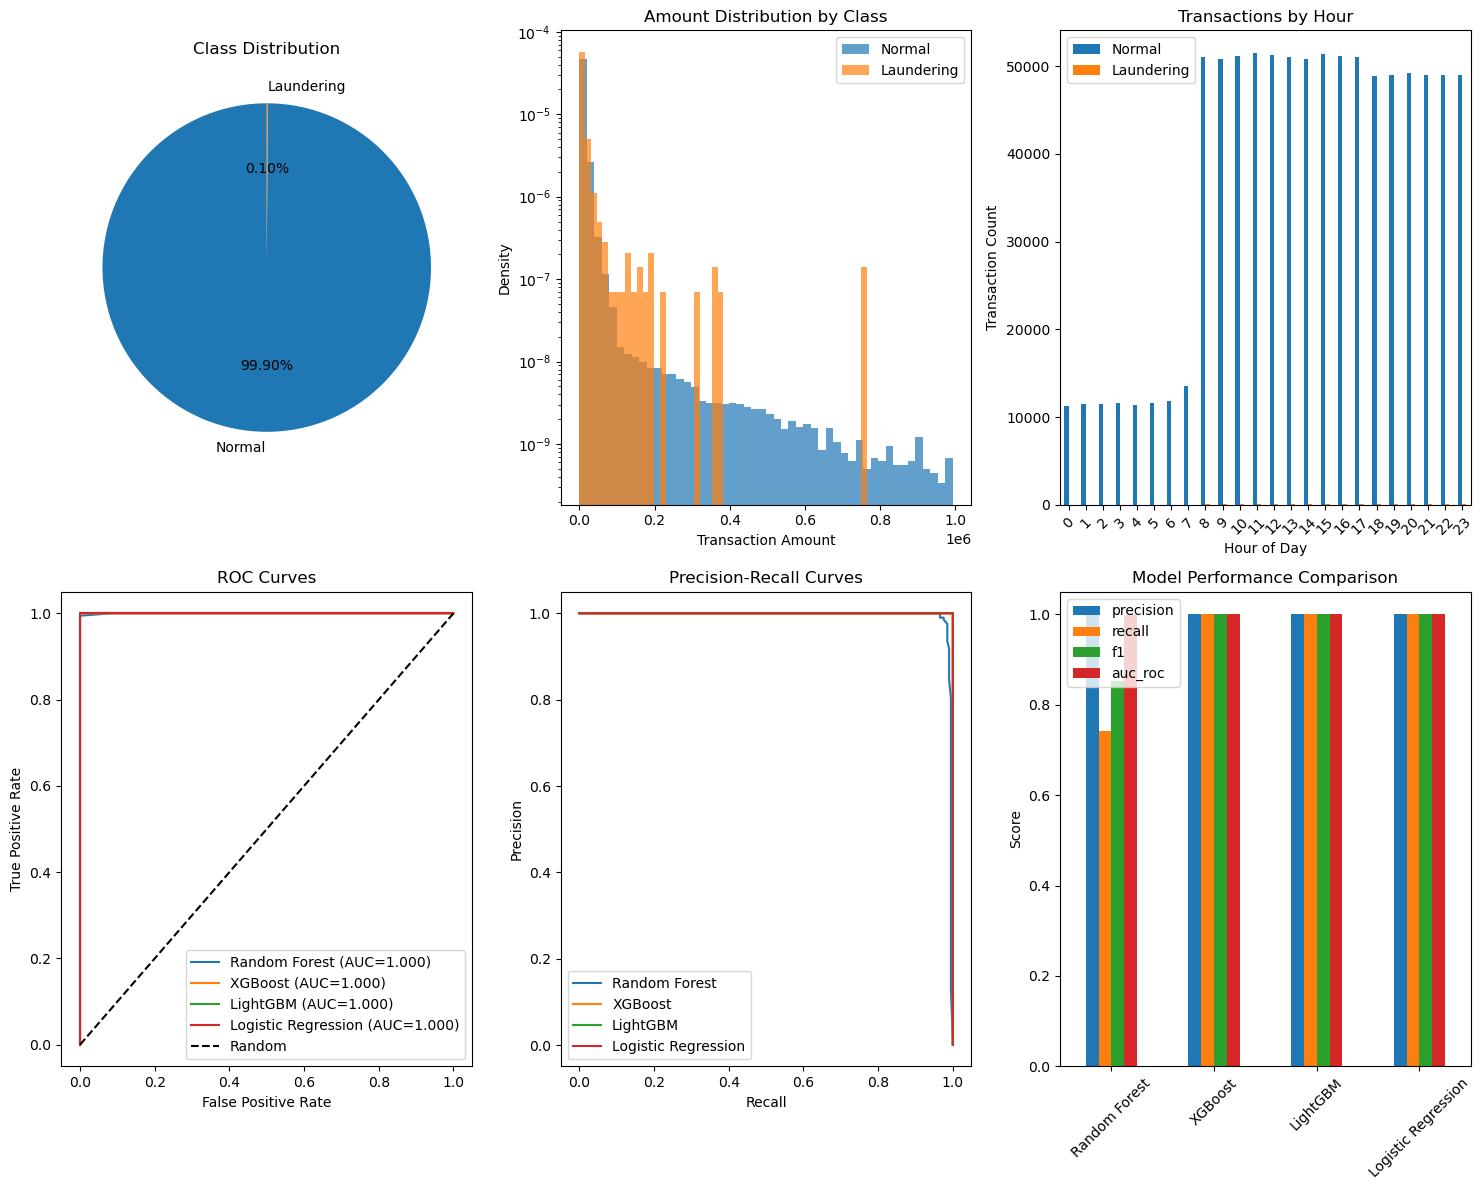

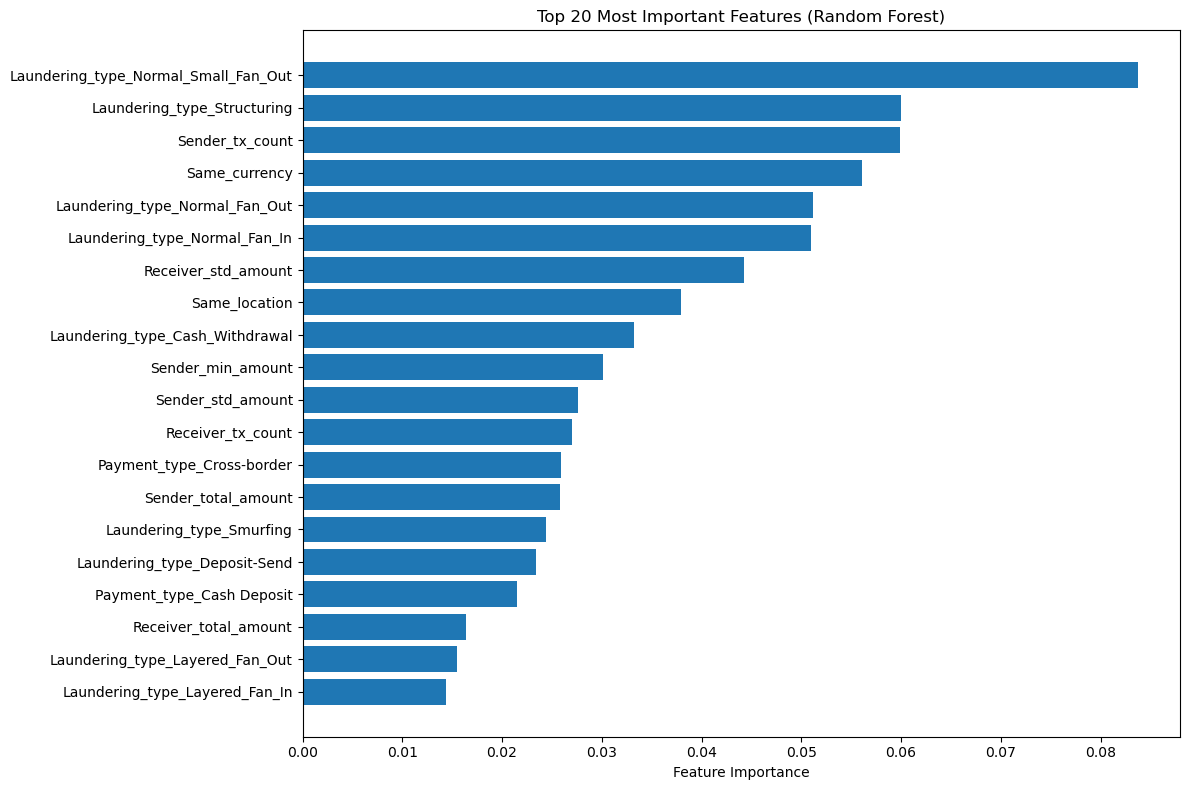


FINAL RESULTS SUMMARY

Random Forest:
  AUC-ROC: 0.9998
  F1-Score: 0.8524
  Precision: 1.0000
  Recall: 0.7427

XGBoost:
  AUC-ROC: 1.0000
  F1-Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

LightGBM:
  AUC-ROC: 1.0000
  F1-Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Logistic Regression:
  AUC-ROC: 1.0000
  F1-Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Best performing model: XGBoost
Best AUC-ROC: 1.0000


In [48]:
# ============================================================================
# EXECUTE THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    models, results, df = main()